# P11 - Modélisez les ventes d'un ensemble de magasin 

## Objectifs
- Caractériser les différentes typologies de magasin de l'enseigne en fonction des caractéristiques de vente et de l'environnement du magasin
- Construire un modèle de prévision des ventes basique puis grâce à des méthodes de prévision des séries temporelles 
- Évaluer la performance des modèles sur un magasin par groupe

## Méthodologie

1. Explorez le jeu de données

*   Chargez les données
*   Déterminez les ordres de grandeur et indicateurs statistiques basiques
*   Préparez le jeu de données pour l'analyse

2. Caractérisez les différentes typologies de magasin

*   Comparez les volumes de vente au mois et à l'année des magasins
*   Déterminez les paramètres influants sur le volume de vente (régression linéaire)
*   Catégorisez les magasins grâce à K-means selon différents critères

3. Construisez un modèle de prévision des ventes

*   Préparez le jeu de données pour entraîner le modèle
*   Entraînez un modèle sur les différents magasin et groupes de magasin
*   Testez une deuxième approche de modélisation 

4. Évaluez la performance du modèle de prévision sur les différents groupes de magasin 

*   Définissez la métrique la plus adaptée
*   Évaluez la performance sur une baseline simple (moyenne sur les 15 derniers jours)
*   Comparez la performance du modèle basé sur les séries temporelles vs l'approche basique pour un magasin par groupe.

# Exploration et préparation des données

In [232]:
#Je commence par importer mes librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from pmdarima import auto_arima

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as sns

In [233]:
#Spécifier le type de données pour la colonne 7 de sales (car message d'erreur)
dtype_dict = {7: "string"}

#Charger les données sales
df_sales = pd.read_csv("sales.csv", decimal=".", index_col=0, dtype=dtype_dict)

#S'assurer que la colonne date est au bon format
df_sales['Date'] = pd.to_datetime(df_sales['Date'])

In [234]:
#Visualiser les données sales chargées
df_sales.head()

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,,,,,,,,
1,5,2015-07-31,5263,555,1,1,0,1
2,5,2015-07-31,6064,625,1,1,0,1
3,5,2015-07-31,8314,821,1,1,0,1
4,5,2015-07-31,13995,1498,1,1,0,1
5,5,2015-07-31,4822,559,1,1,0,1


In [235]:
#Charger les données stores
df_stores = pd.read_csv("stores.csv", decimal =".", index_col =0)

In [236]:
#Visualiser les données stores chargées
df_stores.head()

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,
1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [237]:
#Déterminer les ordres de grandeur
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1017209 entries, 1 to 1115
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   DayOfWeek      1017209 non-null  int64         
 1   Date           1017209 non-null  datetime64[ns]
 2   Sales          1017209 non-null  int64         
 3   Customers      1017209 non-null  int64         
 4   Open           1017209 non-null  int64         
 5   Promo          1017209 non-null  int64         
 6   StateHoliday   1017209 non-null  string        
 7   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(6), string(1)
memory usage: 69.8 MB


In [238]:
#Déterminer indicateurs statistiques de sales
df_sales.describe()

,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,3.998341e+00,2014-04-11 01:30:42.846061824,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
min,1.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,2013-08-17 00:00:00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,6.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,7.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00
std,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01


In [239]:
#Préparer le jeu de données
#Recherche de valeurs nulles ou NaN dans sales
df_sales.isna().sum()

DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [240]:
#Recherche de doublons dans le fichier sales
df_sales.duplicated().sum()

172132

In [241]:
#Suppression des doublons
df_sales = df_sales.drop_duplicates()

In [242]:
#Vérification de la suppression
df_sales.duplicated().sum()

0

In [243]:
#Déterminer les ordres de grandeur de stores
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1115 entries, 1 to 1115
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StoreType                  1115 non-null   object 
 1   Assortment                 1115 non-null   object 
 2   CompetitionDistance        1112 non-null   float64
 3   CompetitionOpenSinceMonth  761 non-null    float64
 4   CompetitionOpenSinceYear   761 non-null    float64
 5   Promo2                     1115 non-null   int64  
 6   Promo2SinceWeek            571 non-null    float64
 7   Promo2SinceYear            571 non-null    float64
 8   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(1), object(3)
memory usage: 87.1+ KB


In [244]:
#Déterminer indicateurs statistiques de stores
df_stores.describe()

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [245]:
#Recherche de doublons dans le fichier stores
df_stores.duplicated().sum()

4

In [246]:
#Suppression des doublons
df_stores = df_stores.drop_duplicates()

In [247]:
#Vérification de la suppression
df_stores.duplicated().sum()

0

In [248]:
#Recherche de valeurs nulles ou NaN dans stores
df_stores.isna().sum()

StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    350
CompetitionOpenSinceYear     350
Promo2                         0
Promo2SinceWeek              540
Promo2SinceYear              540
PromoInterval                540
dtype: int64

In [249]:
#Les colonnes des infos des promos sont vides car ces magasins ne font pas de promos (Promo2 = 0) je choisis donc de remplacer ces cellules par 0
df_stores['Promo2SinceWeek'] = df_stores['Promo2SinceWeek'].fillna(0)
df_stores['Promo2SinceYear'] = df_stores['Promo2SinceYear'].fillna(0)
df_stores['PromoInterval']= df_stores['PromoInterval'].fillna(0)

In [250]:
df_stores.isna().sum()

StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    350
CompetitionOpenSinceYear     350
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

In [251]:
#Je choisis de remplacer les competition distance vides par 0, voulant dire inexistantes
df_stores['CompetitionDistance'] = df_stores['CompetitionDistance'].fillna(0)
df_stores.isna().sum()

StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    350
CompetitionOpenSinceYear     350
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

In [252]:
#Pour les lignes dont les CompetitionDistance sont =0, je voudrais rendre les dates de compétition également nulles
df_stores.loc[df_stores['CompetitionDistance'] == 0, ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']] = 0
df_stores.isna().sum()

StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    347
CompetitionOpenSinceYear     347
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

In [253]:
#Je veux remplacer les mois et années des compétitions vides par la moyenne des colonnes sans les 0

#Calcul de la moyenne de la colonne mois sans les 0
mean_month = df_stores.loc[df_stores['CompetitionOpenSinceMonth'] != 0, 'CompetitionOpenSinceMonth'].mean()

#Remplacement des valeurs vides de cette colonne par la moyenne
df_stores['CompetitionOpenSinceMonth'] = df_stores['CompetitionOpenSinceMonth'].fillna(mean_month)

df_stores.isna().sum()

StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear     347
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

In [254]:
#Calcul de la moyenne de la colonne année sans les 0
mean_year = df_stores.loc[df_stores['CompetitionOpenSinceYear'] != 0, 'CompetitionOpenSinceYear'].mean()

#Remplacement des valeurs vides de cette colonne par la moyenne
df_stores['CompetitionOpenSinceYear'] = df_stores['CompetitionOpenSinceYear'].fillna(mean_year)

df_stores.isna().sum()

StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

# Analyse du CA

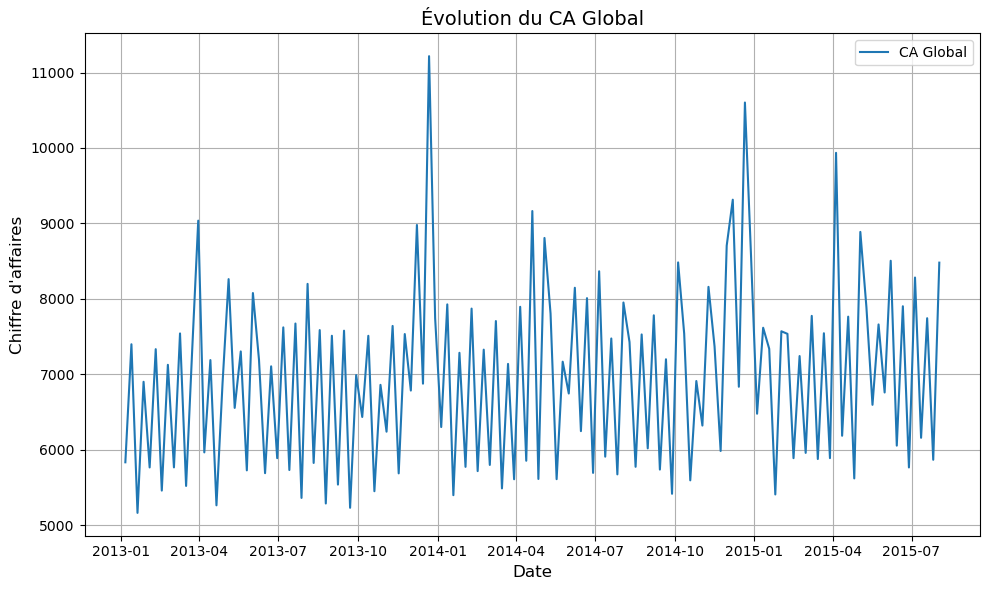

In [256]:
#I.A. Visualisation du CA global

#Trier les données par date
df_sales = df_sales.sort_values(by='Date')

#Ne garder que les colonnes nécessaires
df_sales_CA= df_sales[['Date','Sales']]

#Appliquer le resample pour réduire la densité des données et calculer la moyenne hebdomadaire (car trop de données)
df_sampled = df_sales_CA.resample('W', on='Date').mean()

#Tracer la courbe
plt.figure(figsize=(10, 6))
plt.plot(df_sampled.index, df_sampled['Sales'], marker='', linestyle='-', label='CA Global')

#Ajouter un titre et des axes
plt.title("Évolution du CA Global", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Chiffre d'affaires", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

#Afficher la courbe
plt.show()


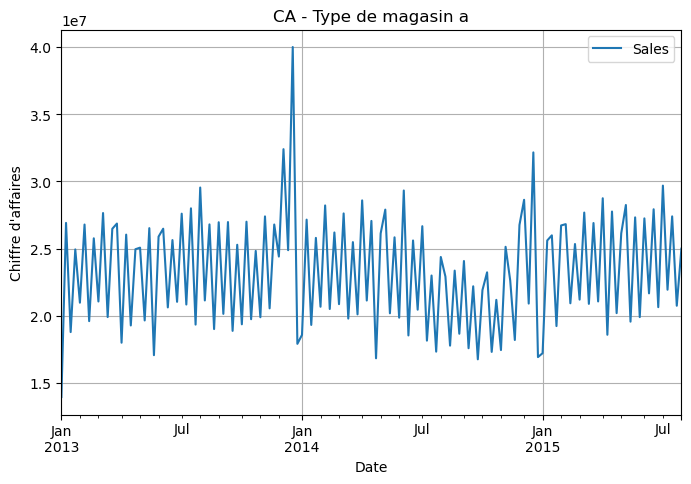

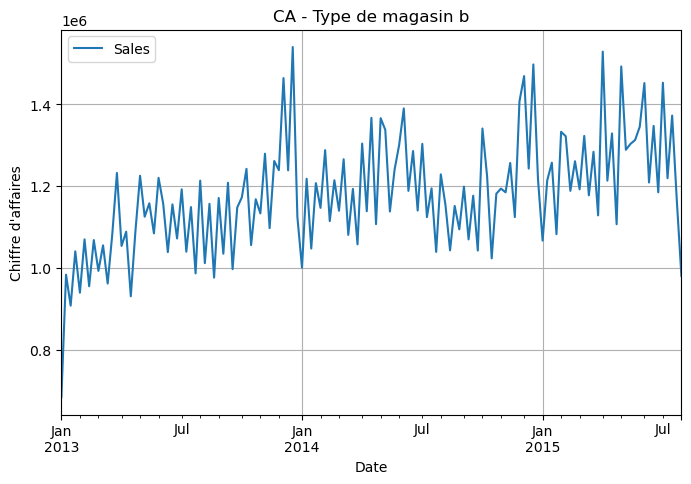

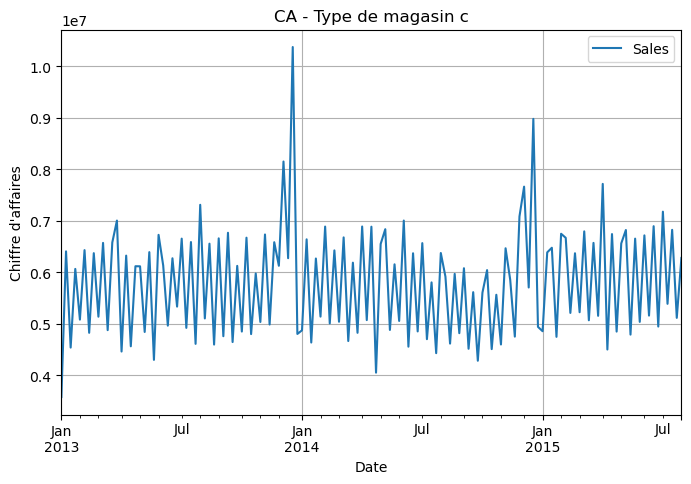

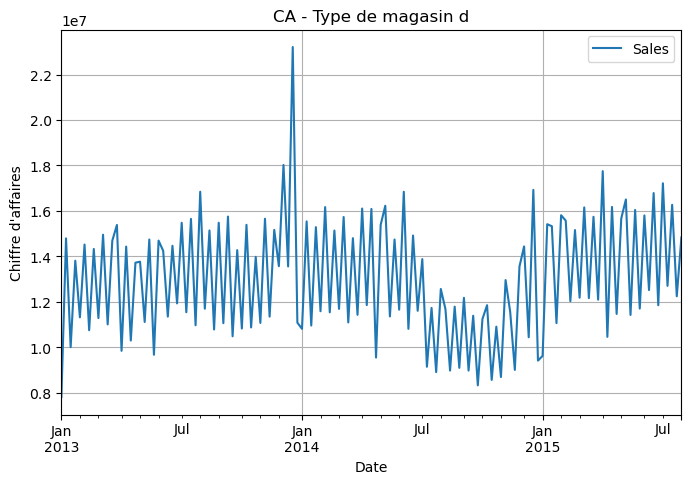

In [257]:
#Visualisation du CA par type de magasin

#Fusionner les deux DataFrames sur la colonne 'Store'
df_merged = pd.merge(df_sales, df_stores, on='Store', how='inner')

#Vérifier que les dates sont au bon format et les classer
df_merged['Date'] = pd.to_datetime(df_merged['Date'])
df_merged = df_merged.sort_values(by='Date')

#Laisser les données de Store en colonne et non en index
df_merged.reset_index(inplace=True)

#Agréger les données par 'StoreType' et par semaine
df_grouped = df_merged.groupby(['StoreType', pd.Grouper(key='Date', freq='W')])['Sales'].sum().reset_index()

#Liste des types de magasins
store_types = df_grouped['StoreType'].unique()

#Tracer un graphique pour chaque type de magasin
for store_type in store_types:
    #Filtrer les données pour ce type de magasin
    df_store_type = df_grouped[df_grouped['StoreType'] == store_type]
    
    #Tracer le graphique
    df_store_type.plot(x='Date', y='Sales', kind='line', title=f"CA - Type de magasin {store_type}", figsize=(8, 5))
    
    #Afficher le graphique
    plt.xlabel("Date")
    plt.ylabel("Chiffre d'affaires")
    plt.grid(True)
    plt.show()


In [258]:
df_merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1097,2,2013-01-01,5961,1405,1,0,a,1,b,b,720.0,3.0,2002.0,0,0.0,0.0,0
1,494,2,2013-01-01,3113,527,1,0,a,1,b,a,1260.0,6.0,2011.0,0,0.0,0.0,0
2,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,0.0,0.0,0
3,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,0.0,0.0,0
4,676,2,2013-01-01,3821,777,1,0,a,1,b,b,1410.0,9.0,2008.0,0,0.0,0.0,0


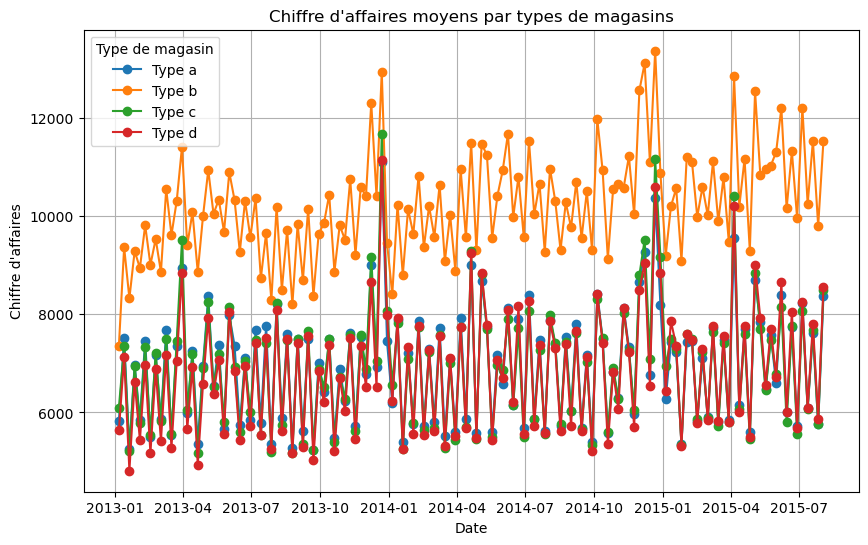

In [259]:
#Faire apparaitre les 4 courbes (en moyenne) sur un seul graphique

#Agréger les données par 'StoreType' et par semaine
df_grouped1 = df_merged.groupby(['StoreType', pd.Grouper(key='Date', freq='W')])['Sales'].mean().reset_index()

#Initialiser la figure
plt.figure(figsize=(10, 6))

#Tracer les courbes pour chaque type de magasin
for store_type in df_grouped1['StoreType'].unique():
    df_store_type = df_grouped1[df_grouped1['StoreType'] == store_type]
    plt.plot(df_store_type['Date'], df_store_type['Sales'], marker='o', linestyle='-', label=f"Type {store_type}")

#Personnalisation du graphique
plt.title("Chiffre d'affaires moyens par types de magasins")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend(title="Type de magasin")
plt.grid(True)

#Afficher le graphique
plt.show()


In [260]:
#Statistiques du nombre de magasins par type
nombre_store = df_merged.groupby('StoreType')['Store'].nunique()

#Affichage des résultats
for store_type, count in nombre_store.items():
    print(f"Il y a {count} magasins de type {store_type}.")

Il y a 599 magasins de type a.
Il y a 17 magasins de type b.
Il y a 148 magasins de type c.
Il y a 347 magasins de type d.


# Analyse des relations et catégorisations

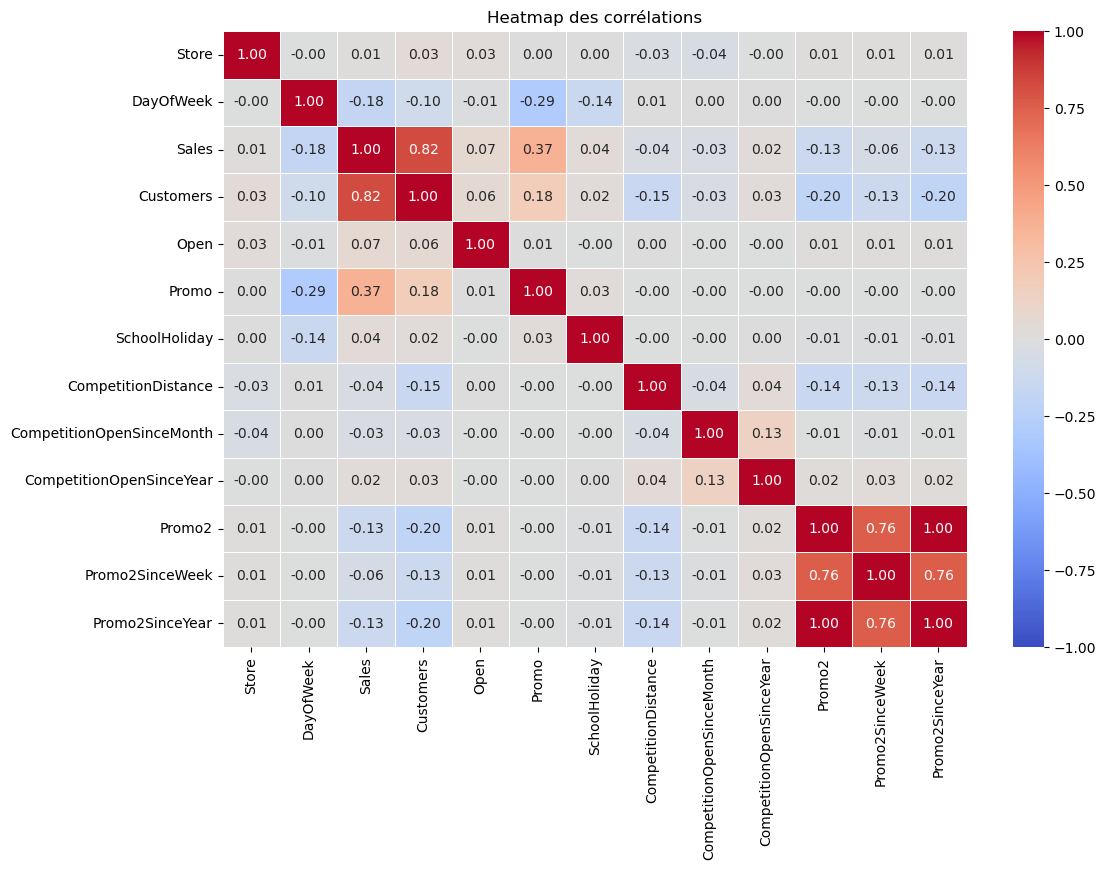

In [262]:
#I.B. Faire une matrice de corrélation

#Sélectionner uniquement les colonnes numériques pour la heatmap
df_numeric = df_merged.select_dtypes(include=['number'])

#Calculer la matrice de corrélation
correlation_matrix = df_numeric.corr()

#Tracer la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Heatmap des corrélations")
plt.show()

#Difficile d'en tirer de réelles connexions mais cela démontre bien la relation
#entre le nombre de clients qui visitent le magasin et les ventes (-1 : corrélation négative parfaite, 0 : aucune 
#corrélation , 1 : corrélation positive parfaite)

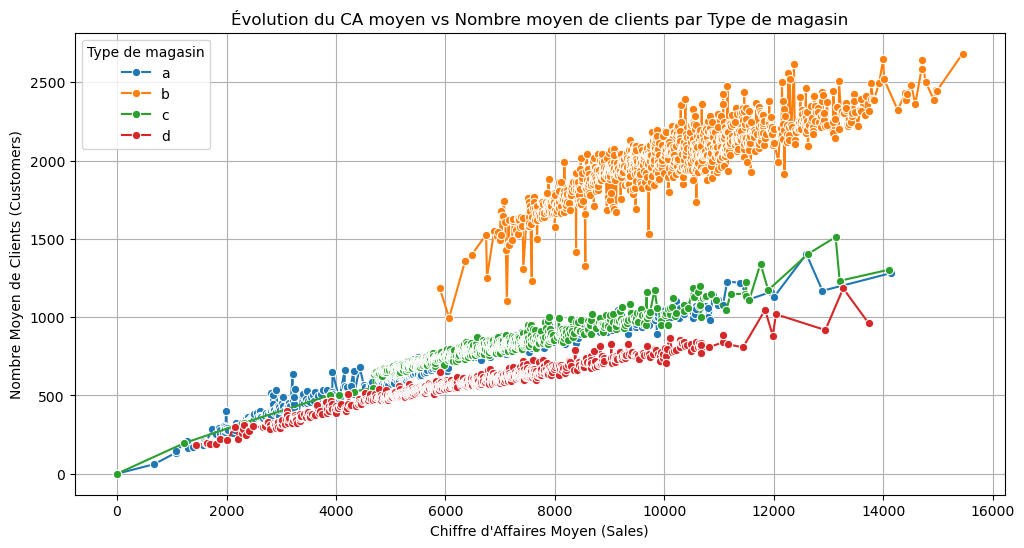

In [263]:
#Pour mieux étudier cela je vais faire un graphique montrant l'évolution du CA par rapport au nombre de clients pour
#les différents types de magasin

#Regrouper les données par StoreType et Date pour calculer les moyennes
df_grouped = df_merged.groupby(["Date", "StoreType"])[["Sales", "Customers"]].mean().reset_index()

#Convertir la colonne Date en format datetime pour une meilleure visualisation
df_grouped["Date"] = pd.to_datetime(df_grouped["Date"])

#Tracer un graphique linéaire
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped, x="Sales", y="Customers", hue="StoreType", marker="o")

#Personnalisation du graphique
plt.xlabel("Chiffre d'Affaires Moyen (Sales)")
plt.ylabel("Nombre Moyen de Clients (Customers)")
plt.title("Évolution du CA moyen vs Nombre moyen de clients par Type de magasin")
plt.legend(title="Type de magasin")
plt.grid(True)
plt.show()


<Figure size 1200x600 with 0 Axes>

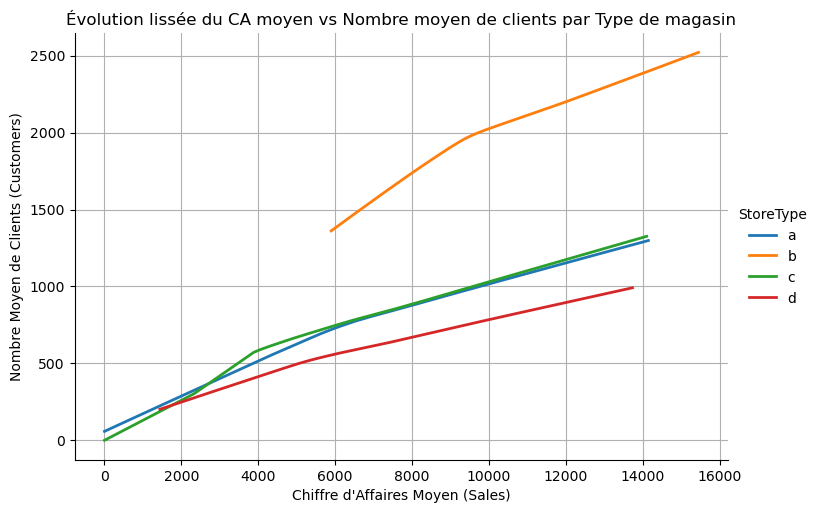

In [264]:
#Je choisis de lisser les courbes pour une meilleure visibilité

#Tracer le graphique linéaire avec une courbe lissée (avec lowess)
plt.figure(figsize=(12, 6))

#Tracer une courbe lissée pour chaque type de magasin
sns.lmplot(
    data=df_grouped, x="Sales", y="Customers", hue="StoreType", 
    lowess=True, aspect=1.5, scatter=False, line_kws={"linewidth": 2}
)

#Personnalisation du graphique
plt.xlabel("Chiffre d'Affaires Moyen (Sales)")
plt.ylabel("Nombre Moyen de Clients (Customers)")
plt.title("Évolution lissée du CA moyen vs Nombre moyen de clients par Type de magasin")
plt.grid(True)

#Afficher le graphique
plt.show()


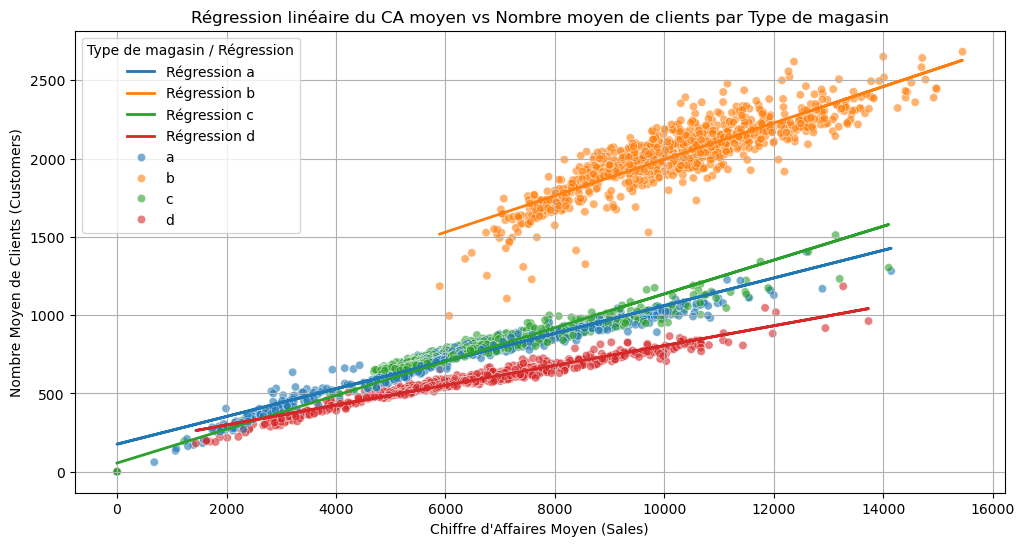

Équations des régressions linéaires :
a: y = 0.09x + 175.98
b: y = 0.12x + 832.46
c: y = 0.11x + 55.43
d: y = 0.06x + 171.79


In [265]:
#Je choisis ensuite de faire une régression linéaire sur mes courbes

#Tracer le graphique
plt.figure(figsize=(12, 6))

#Lister les types de magasins uniques
store_types = df_grouped["StoreType"].unique()

#Stocker les équations des régressions
equations = []

#Tracer une régression linéaire pour chaque type de magasin
for store_type in store_types:
    #Filtrer les données par StoreType
    df_filtered = df_grouped[df_grouped["StoreType"] == store_type]
    
    #Vérifier que nous avons suffisamment de points pour la régression (car erreur)
    if len(df_filtered) > 1:
        # Variables indépendantes (X) et dépendantes (Y)
        X = df_filtered["Sales"].values.reshape(-1, 1)  # CA moyen
        y = df_filtered["Customers"].values  # Nombre moyen de clients
        
        #Ajouter une constante pour le modèle (nécessaire pour statsmodels)
        X = sm.add_constant(X)
        
        #Modèle de régression linéaire
        model = sm.OLS(y, X).fit()

         #Extraire les coefficients
        b = model.params[0]  # Constante
        a = model.params[1]  # Pente
        
        #Prédictions
        y_pred = model.predict(X)
        
        #Tracer la ligne de régression
        plt.plot(df_filtered["Sales"], y_pred, label=f"Régression {store_type}", linewidth=2)

         #Stocker l'équation sous forme de texte
        equation = f"{store_type}: y = {a:.2f}x + {b:.2f}"
        equations.append(equation)

#Tracer les points originaux avec Seaborn pour une meilleure visualisation (recommandation)
sns.scatterplot(data=df_grouped, x="Sales", y="Customers", hue="StoreType", alpha=0.6)

#Personnalisation du graphique
plt.xlabel("Chiffre d'Affaires Moyen (Sales)")
plt.ylabel("Nombre Moyen de Clients (Customers)")
plt.title("Régression linéaire du CA moyen vs Nombre moyen de clients par Type de magasin")
plt.legend(title="Type de magasin / Régression")
plt.grid(True)

#Afficher le graphique
plt.show()

#Afficher les équations dans la console
print("Équations des régressions linéaires :")
for eq in equations:
    print(eq)


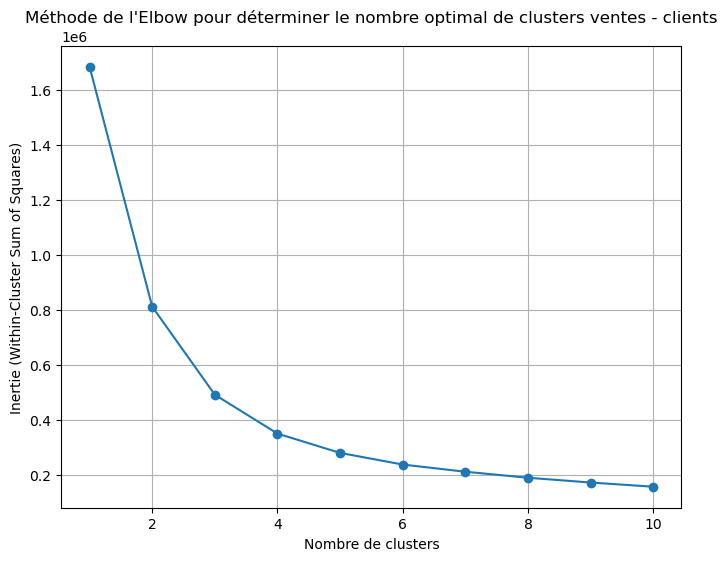

In [266]:
#Application de la méthode du coude pour trouver le nombre de clusters à appliquer ventes - clients

# Sélection des colonnes pour la méthode de l'Elbow
df_clustering_elbow = df_merged[['Sales','Customers']].copy()

# Standardisation des données pour l'Elbow
scaler_elbow = StandardScaler()
df_clustering_scaled_elbow = scaler_elbow.fit_transform(df_clustering_elbow)

# Méthode de l'Elbow pour déterminer le nombre optimal de clusters
inertias = []
cluster_range = range(1, 11)  # Test de 1 à 10 clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=93, n_init=10)
    kmeans.fit(df_clustering_scaled_elbow)
    inertias.append(kmeans.inertia_)

# Tracer la courbe de l'Elbow
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertias, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie (Within-Cluster Sum of Squares)")
plt.title("Méthode de l'Elbow pour déterminer le nombre optimal de clusters ventes - clients")
plt.grid(True)
plt.show()


Centres des clusters (standardisés) :
[[ 0.12988873  0.04533565]
 [-0.78856226 -0.67491729]
 [ 3.23332345  4.12993572]
 [ 1.3297745   1.09160803]]


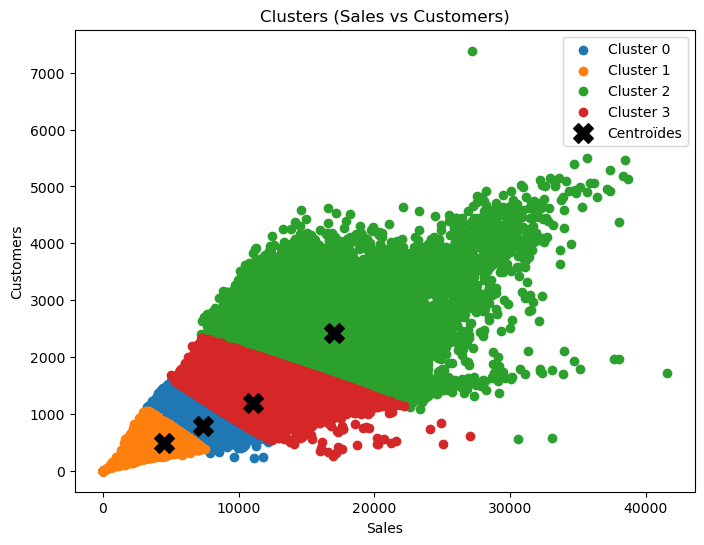

In [267]:
#I.C. catégorises les magasins grâce à un algorithme de clustering selon différents critères (il nous faut au minimum 4 groupes).
# en me basant sur la heatmap je choisis les critères suivants : nombre de clients, nombre de ventes

#Sélection des colonnes
df_clustering = df_merged[['Sales', 'Customers']].copy()

#Standardisation des données
scaler = StandardScaler()
df_clustering_scaled = scaler.fit_transform(df_clustering)

#Application des K-means (+ rajoute la colonne Cluster à mon dataframe)
kmeans = KMeans(n_clusters=4, random_state=93, n_init=10)
df_merged['Cluster'] = kmeans.fit_predict(df_clustering_scaled)

#Analyse des clusters
print("Centres des clusters (standardisés) :")
print(kmeans.cluster_centers_)

#Déstandardiser les centroïdes pour les afficher correctement (car erreur)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

#Visualisation des clusters (Sales vs Customers)
plt.figure(figsize=(8, 6))
for cluster in range(4):
    cluster_data = df_merged[df_merged['Cluster'] == cluster]
    plt.scatter(cluster_data['Sales'], cluster_data['Customers'], label=f"Cluster {cluster}")

#Tracer les centroïdes
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label="Centroïdes")

#Personnalisation du graphique
plt.xlabel('Sales')
plt.ylabel('Customers')
plt.title('Clusters (Sales vs Customers)')
plt.legend()
plt.show()

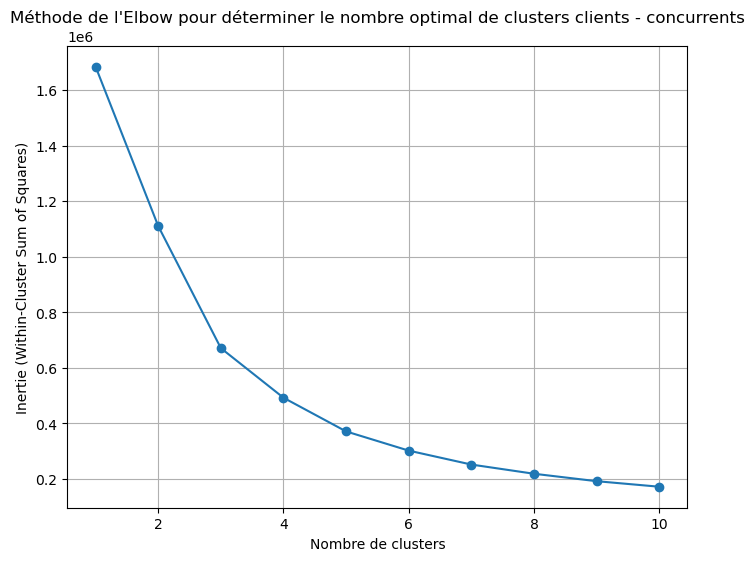

In [268]:
#Application de la méthode du coude pour trouver le nombre de clusters à appliquer clients - concurrents

# Sélection des colonnes pour la méthode de l'Elbow
df_clustering2_elbow = df_merged[['Customers', 'CompetitionDistance']].copy()

# Standardisation des données pour l'Elbow
scaler_elbow = StandardScaler()
df_clustering2_scaled_elbow = scaler_elbow.fit_transform(df_clustering2_elbow)

# Méthode de l'Elbow pour déterminer le nombre optimal de clusters
inertias = []
cluster_range = range(1, 11)  # Test de 1 à 10 clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=93, n_init=10)
    kmeans.fit(df_clustering2_scaled_elbow)
    inertias.append(kmeans.inertia_)

# Tracer la courbe de l'Elbow
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertias, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie (Within-Cluster Sum of Squares)")
plt.title("Méthode de l'Elbow pour déterminer le nombre optimal de clusters clients - concurrents")
plt.grid(True)
plt.show()


Centres des clusters 2 (standardisés) :
[[ 0.72944968 -0.45084946]
 [-0.49608564 -0.26429254]
 [-0.2274582   2.00299909]
 [ 3.92264244 -0.58792979]]


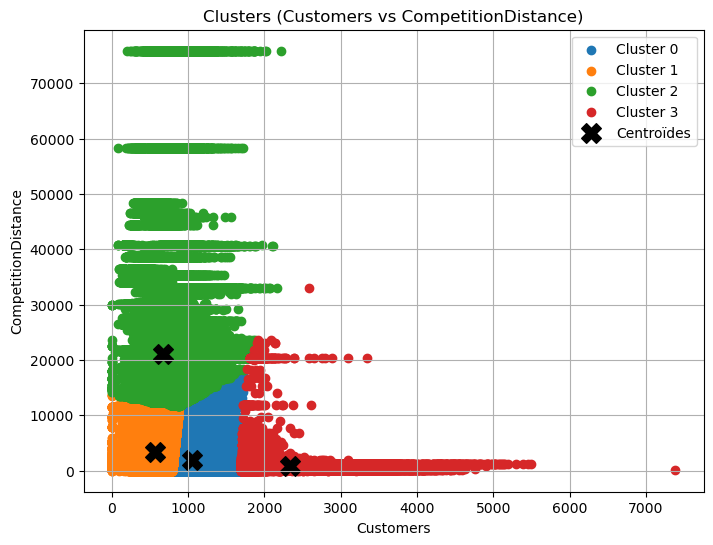

In [269]:
#Puis pour étudier une autre piste, essai avec clients et CompetitionDistance

#Sélection des colonnes
df_clustering2 = df_merged[['Customers', 'CompetitionDistance']].copy()

#Standardisation des données
scaler = StandardScaler()
df_clustering2_scaled = scaler.fit_transform(df_clustering2)

#Application des K-means (+ rajoute la colonne Cluster à mon dataframe)
kmeans_2 = KMeans(n_clusters=4, random_state=93, n_init=10)
df_merged['Cluster2'] = kmeans_2.fit_predict(df_clustering2_scaled)

#Analyse des clusters
print("Centres des clusters 2 (standardisés) :")
print(kmeans_2.cluster_centers_)

#Déstandardisation des centroïdes (car erreur)
centroids = scaler.inverse_transform(kmeans_2.cluster_centers_)

#Visualisation des clusters (Sales vs Customers)
plt.figure(figsize=(8, 6))
for cluster2 in range(4):
    cluster2_data = df_merged[df_merged['Cluster2'] == cluster2]
    plt.scatter(cluster2_data['Customers'], cluster2_data['CompetitionDistance'], label=f"Cluster {cluster2}")

#Ajouter les centroïdes
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label="Centroïdes")

#Personnalisation du graphique
plt.xlabel('Customers')
plt.ylabel('CompetitionDistance')
plt.title('Clusters (Customers vs CompetitionDistance)')
plt.legend()
plt.grid(True)
plt.show()

# Prévision des ventes

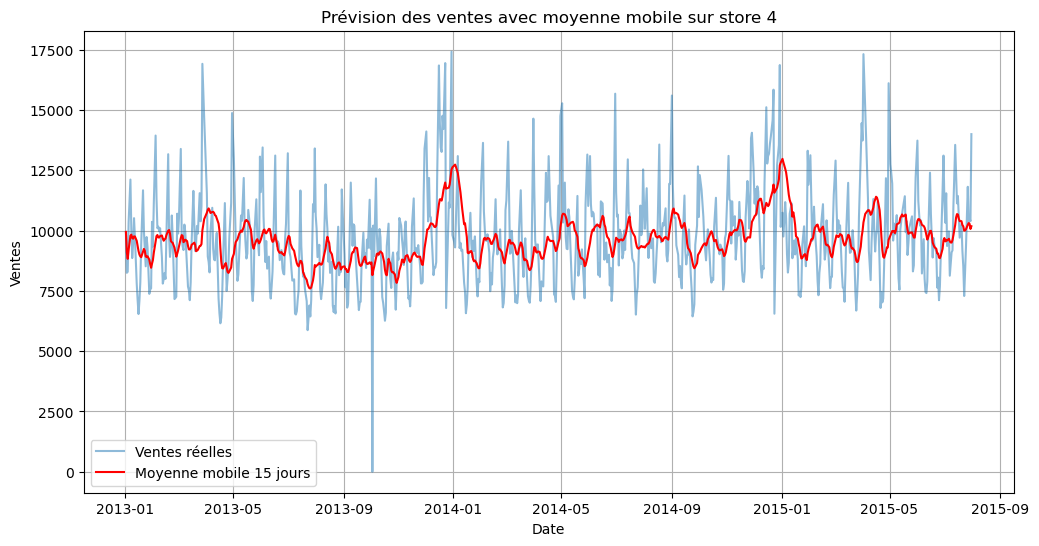

In [271]:
#Modélisation par moyenne glissante sur un magasin en particulier (Store 4)

#Filtrer les données pour le store 4
df_A = df_merged[df_merged['Store'] == 4][['Date', 'Sales']].copy()

#Convertir la colonne Date en datetime
df_A['Date'] = pd.to_datetime(df_A['Date'], errors='coerce')

#Supprimer les lignes avec des dates non valides
df_A = df_A.dropna(subset=['Date'])

#Trier les données par date
df_A = df_A.sort_values(by='Date')

#Calculer la moyenne glissante sur les 15 derniers jours (15 dernières lignes du df)
df_A['Sales_MA_15A'] = df_A['Sales'].rolling(window=15, min_periods=1).mean()


#Visualisation de l'évolution des ventes avec la moyenne mobile
plt.figure(figsize=(12,6))
plt.plot(df_A['Date'], df_A['Sales'], label='Ventes réelles', alpha=0.5)
plt.plot(df_A['Date'], df_A['Sales_MA_15A'], label='Moyenne mobile 15 jours', color='red')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.title('Prévision des ventes avec moyenne mobile sur store 4')
plt.legend()
plt.grid(True)
plt.show()

In [272]:
#Pour pouvoir ensuite tester mon SARIMA, j'aimerais savoir si les données contenues dans sales se retrouvent dans test

#Charger les données test
df_test = pd.read_csv("test.csv", decimal =".", index_col =0)

#Vérifier si toutes les lignes de df_test existent dans df_sales
is_subset = df_test.apply(tuple, axis=1).isin(df_sales.apply(tuple, axis=1))

#Vérifier si toutes les lignes de df_test sont présentes dans df_sales
all_rows_present = is_subset.all()

#Affichage du résultat
if all_rows_present:
    print("Toutes les données du DataFrame 'test' sont présentes dans 'sales'.")
else:
    print("Certaines données du DataFrame 'test' ne sont pas présentes dans 'sales'.")

#Afficher les lignes de test qui ne sont pas dans sales
missing_rows = df_test[~is_subset]

missing_rows.info()

# Aucune des lignes du fichier Test (41088 lignes) ne se retrouve dans Sales je ne peux donc pas vérifier si les ventes prévues par mon modèle de 
# prédiction sont les bonnes ou non. Je vais donc découper mon jeu de données en 2 et entrainer mon SARIMA sur 80% et le tester sur 20%

Certaines données du DataFrame 'test' ne sont pas présentes dans 'sales'.
<class 'pandas.core.frame.DataFrame'>
Index: 41088 entries, 1 to 41088
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Store          41088 non-null  int64  
 1   DayOfWeek      41088 non-null  int64  
 2   Date           41088 non-null  object 
 3   Open           41077 non-null  float64
 4   Promo          41088 non-null  int64  
 5   StateHoliday   41088 non-null  object 
 6   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 2.5+ MB


Date            0
Sales           0
Sales_MA_15A    0
dtype: int64


C:\Users\ngami\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


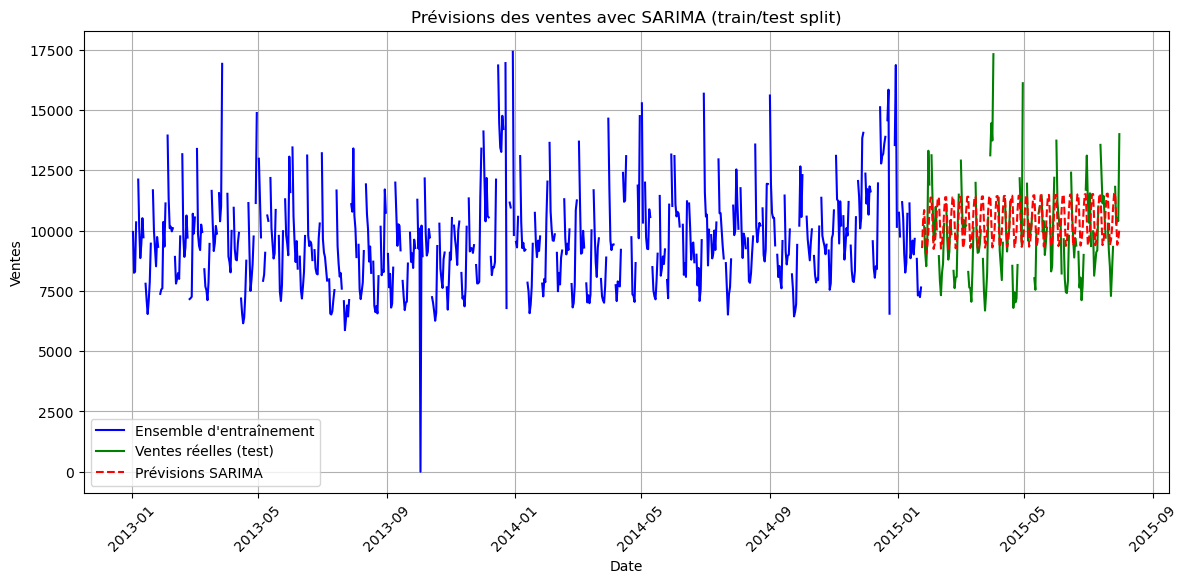

In [273]:
# Prévision SARIMA sur Store 4 : entrainement sur Train puis Test

#Filtrer les données pour le store 4
df_merged4 = df_merged[df_merged['Store'] == 4][['Date', 'Sales']].copy()

# Ajout de la colonne 'Sales_MA_15A' depuis df_A
df_merged4['Sales_MA_15A'] = df_A['Sales_MA_15A'].values

print(df_merged4.isna().sum())

#Mettre 'Date' au format datetime et indexé
df_merged4['Date'] = pd.to_datetime(df_merged4['Date'])
df_merged4.set_index('Date', inplace=True)

#Trier les données par date
df_merged4 = df_merged4.sort_values(by='Date')

#Supprimer les doublons (pour éviter l'erreur)
df_merged4 = df_merged4[~df_merged4.index.duplicated(keep='first')]

#Préciser la fréquence journalière (car erreur)
df_merged4 = df_merged4.asfreq('D')

#Division des données
df_merged_train, df_merged_test = train_test_split(df_merged4, test_size=0.2, shuffle=False)
#(random_state=42 : Permet de reproduire les mêmes résultats à chaque exécution du code)

#Entraînement  un modèle SARIMA avec une saisonnalité journalière
sarima_model = SARIMAX(df_merged_train['Sales'], 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 7), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit(disp=False)

#Prévision sur l'ensemble de test
forecast = sarima_fit.get_forecast(steps=len(df_merged_test))
forecast_values = forecast.predicted_mean

#Visualisation des résultats
plt.figure(figsize=(14, 6))
plt.plot(df_merged_train.index, df_merged_train['Sales'], label='Ensemble d\'entraînement', color='blue')
plt.plot(df_merged_test.index, df_merged_test['Sales'], label='Ventes réelles (test)', color='green')
plt.plot(df_merged_test.index, forecast_values, label='Prévisions SARIMA', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.title('Prévisions des ventes avec SARIMA (train/test split)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


# Comparaison des performances

Performances du modèle SARIMA :
MAE (Mean Absolute Error) : 1026.90
RMSE (Root Mean Squared Error) : 1263.22

Performances du modèle de Moyenne Mobile :
MAE (Mean Absolute Error) : 1131.80
RMSE (Root Mean Squared Error) : 1579.12


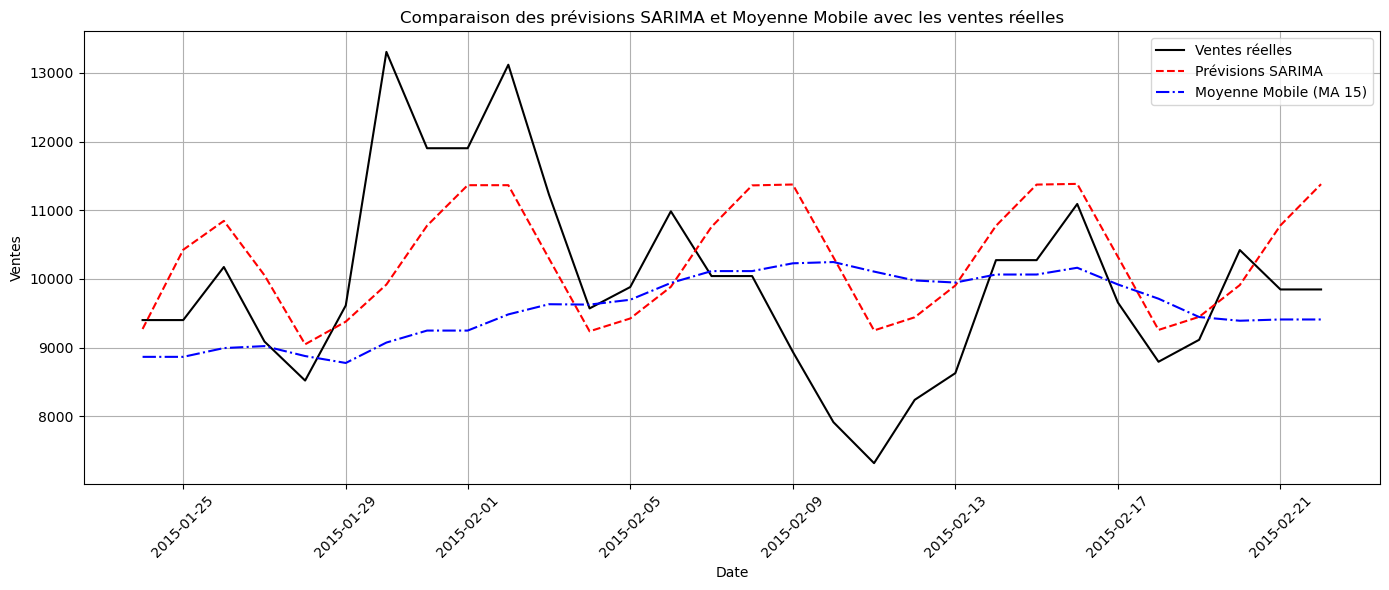

In [275]:
#Comparaison des performances

# 1. Définition des prévisions SARIMA et les limiter à 30 jours pour coller avec moyenne mobile
forecast_values_30 = forecast_values.iloc[:30]

# 2. Définition des prévisions par Moyenne Mobile (assurez-vous que cela correspond aux mêmes dates)
ma_predictions_merged4 = df_merged_test['Sales_MA_15A'].iloc[:30]  # Utiliser les 30 premiers jours de df_merged_test

# 3. Alignement des données (30 derniers jours pour correspondre aux prévisions)
df_merged_test_last30 = df_merged_test.iloc[:30]  # Correspondre aux prévisions SARIMA

# Vérification des valeurs manquantes (car erreur)
#print(df_merged_test_last30['Sales'].isna().sum(), forecast_values_30.isna().sum(), ma_predictions_merged4.isna().sum())

# Traitement des NaN (rajout de .loc car avertissement)
df_merged_test_last30.loc[:, 'Sales'] = df_merged_test_last30['Sales'].ffill()
forecast_values_30 = forecast_values_30.ffill()
ma_predictions_merged4 = ma_predictions_merged4.ffill()

# Calcul des métriques pour SARIMA
mae_sarima = mean_absolute_error(df_merged_test_last30['Sales'], forecast_values_30)
rmse_sarima = sqrt(mean_squared_error(df_merged_test_last30['Sales'], forecast_values_30))

# 6. Calcul des métriques pour la moyenne mobile
mae_ma = mean_absolute_error(df_merged_test_last30['Sales'], ma_predictions_merged4)
rmse_ma = sqrt(mean_squared_error(df_merged_test_last30['Sales'], ma_predictions_merged4))

# 7. Affichage des résultats
print("Performances du modèle SARIMA :")
print(f"MAE (Mean Absolute Error) : {mae_sarima:.2f}")
print(f"RMSE (Root Mean Squared Error) : {rmse_sarima:.2f}\n")

print("Performances du modèle de Moyenne Mobile :")
print(f"MAE (Mean Absolute Error) : {mae_ma:.2f}")
print(f"RMSE (Root Mean Squared Error) : {rmse_ma:.2f}")

# Graphique des prévisions vs ventes réelles
plt.figure(figsize=(14, 6))
plt.plot(df_merged_test_last30.index, df_merged_test_last30['Sales'], label='Ventes réelles', color='black')
plt.plot(df_merged_test_last30.index, forecast_values_30, label='Prévisions SARIMA', color='red', linestyle='--')
plt.plot(df_merged_test_last30.index, ma_predictions_merged4, label='Moyenne Mobile (MA 15)', color='blue', linestyle='-.')

plt.title("Comparaison des prévisions SARIMA et Moyenne Mobile avec les ventes réelles")
plt.xlabel("Date")
plt.ylabel("Ventes")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [276]:
#Pour aller plus loin et rendre plus fiable le modèle SARIMA on pourrait utiliser pmdarima qui afficherait automatiquement
#les meilleurs paramètres de notre modèle SARIMA

#Définition automatique des paramètres
#from pmdarima import auto_arima

# Recherche automatique des meilleurs paramètres SARIMA
#auto_model = auto_arima(df_merged_train['Sales'],
                       # seasonal=True, 
                       # m=7,               # Saisonnalité hebdomadaire
                       # trace=True,        # Affiche les itérations
                       # error_action='ignore', 
                       # suppress_warnings=True, 
                       # stepwise=True)     # Optimisation plus rapide

#print(auto_model.summary())


In [277]:
#téléchargement du fichier
#df_merged.to_csv('df_merged.csv', index=False)